In [16]:
import pandas as pd
import numpy as np

from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score

import matplotlib.pyplot as plt

Dataset taken from https://www.kaggle.com/tmdb/tmdb-movie-metadata

In [2]:
data_filepath = 'https://s3.amazonaws.com/assets.datacamp.com/production/course_974/datasets/'
df = pd.read_csv(data_filepath + 'merged_movie_data.csv')

In [3]:
df.head()

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,...,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,movie_id,cast
0,237000000,"Action, Adventure, Fantasy, Science Fiction",http://www.avatarmovie.com/,19995,"culture clash, future, space war, space colony...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"Ingenious Film Partners, Twentieth Century Fox...",...,2787965087,162.0,"English, Español",Released,Enter the World of Pandora.,Avatar,7.2,11800,19995,"Sam Worthington, Zoe Saldana, Sigourney Weaver..."
1,300000000,"Adventure, Fantasy, Action",http://disney.go.com/disneypictures/pirates/,285,"ocean, drug abuse, exotic island, east india t...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"Walt Disney Pictures, Jerry Bruckheimer Films,...",...,961000000,169.0,English,Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,285,"Johnny Depp, Orlando Bloom, Keira Knightley, S..."
2,245000000,"Action, Adventure, Crime",http://www.sonypictures.com/movies/spectre/,206647,"spy, based on novel, secret agent, sequel, mi6...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"Columbia Pictures, Danjaq, B24",...,880674609,148.0,"Français, English, Español, Italiano, Deutsch",Released,A Plan No One Escapes,Spectre,6.3,4466,206647,"Daniel Craig, Christoph Waltz, Léa Seydoux, Ra..."
3,250000000,"Action, Crime, Drama, Thriller",http://www.thedarkknightrises.com/,49026,"dc comics, crime fighter, terrorist, secret id...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"Legendary Pictures, Warner Bros., DC Entertain...",...,1084939099,165.0,English,Released,The Legend Ends,The Dark Knight Rises,7.6,9106,49026,"Christian Bale, Michael Caine, Gary Oldman, An..."
4,260000000,"Action, Adventure, Science Fiction",http://movies.disney.com/john-carter,49529,"based on novel, mars, medallion, space travel,...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,Walt Disney Pictures,...,284139100,132.0,English,Released,"Lost in our world, found in another.",John Carter,6.1,2124,49529,"Taylor Kitsch, Lynn Collins, Samantha Morton, ..."


In [4]:
df['profitable'] = df.revenue > df.budget
df['profitable'] = df['profitable'].astype(int)

regression_target = 'revenue'
classification_target = 'profitable'

In [5]:
df = df.replace([np.inf, -np.inf], np.nan)
df = df.dropna(how='any')

In [6]:
list_genres = df.genres.apply(lambda x: x.split(","))
genres = []
for row in list_genres:
    row = [genre.strip() for genre in row]
    for genre in row:
        if genre not in genres:
            genres.append(genre)

for genre in genres:
    df[genre] = df['genres'].str.contains(genre).astype(int)
    
df[genres].head()

,Action,Adventure,Fantasy,Science Fiction,Crime,Drama,Thriller,Animation,Family,Western,Comedy,Romance,Horror,Mystery,War,History,Music,Documentary,TV Movie,Foreign
0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


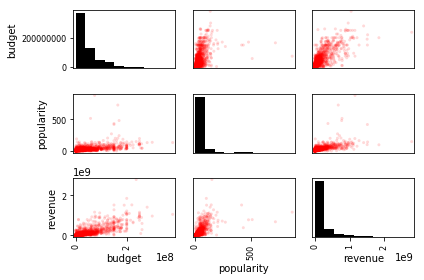

budget          1.754872
popularity      7.968139
runtime         1.059804
vote_count      2.461041
vote_average   -1.080038
revenue         3.084680
profitable     -1.081030
dtype: float64


In [7]:
continuous_covariates = ['budget', 'popularity', 'runtime', 'vote_count', 'vote_average']
outcomes_and_continuous_covariates = continuous_covariates + [regression_target, classification_target]
plotting_variables = ['budget', 'popularity', regression_target]

axes = pd.plotting.scatter_matrix(df[plotting_variables], alpha = 0.15,color=(0,0,0),hist_kwds={"color":(0,0,0)},facecolor=(1,0,0))
plt.tight_layout()
plt.show()

print(df[outcomes_and_continuous_covariates].skew())

In [8]:
for covariate in ['budget', 'popularity', 'runtime', 'vote_count', 'revenue']:
    df[covariate] = df[covariate].apply(lambda x: np.log10(1+x))

In [9]:
all_covariates = continuous_covariates + genres
all_columns = [regression_target, classification_target] + all_covariates

# Define all covariates and outcomes from `df`.
regression_outcome = df[regression_target]
classification_outcome = df[classification_target]
covariates = df[all_covariates]

# Instantiate all regression models and classifiers.
linear_regression = LinearRegression()
logistic_regression = LogisticRegression()
forest_regression = RandomForestRegressor(max_depth=4, random_state=0)
forest_classifier = RandomForestClassifier(max_depth=4, random_state=0)

In [10]:
def correlation(estimator, X, y):
    predictions = estimator.fit(X, y).predict(X)
    return r2_score(y, predictions)

def accuracy(estimator, X, y):
    predictions = estimator.fit(X, y).predict(X)
    return accuracy_score(y, predictions)

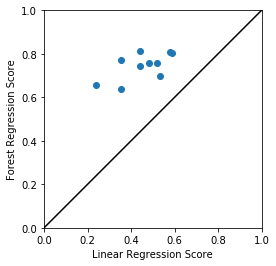

In [11]:
# Determine the cross-validated correlation for linear and random forest models.
linear_regression_scores = cross_val_score(linear_regression, covariates, regression_outcome, cv=10, scoring=correlation)
forest_regression_scores = cross_val_score(forest_regression, covariates, regression_outcome, cv=10, scoring=correlation)

# Plot Results
plt.axes().set_aspect('equal', 'box')
plt.scatter(linear_regression_scores, forest_regression_scores)
plt.plot((0, 1), (0, 1), 'k-')

plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel("Linear Regression Score")
plt.ylabel("Forest Regression Score")

# Show the plot.
plt.show()

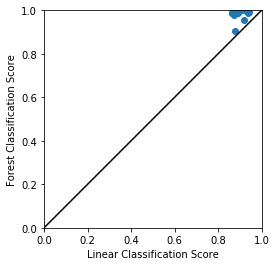

In [12]:
# Determine the cross-validated accuracy for logistic and random forest models.
logistic_regression_scores = cross_val_score(logistic_regression, covariates, classification_outcome, cv=10, scoring=accuracy)
forest_classification_scores = cross_val_score(forest_classifier, covariates, classification_outcome, cv=10, scoring=accuracy)

# Plot Results
plt.axes().set_aspect('equal', 'box')
plt.scatter(logistic_regression_scores, forest_classification_scores)
plt.plot((0, 1), (0, 1), 'k-')

plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel("Linear Classification Score")
plt.ylabel("Forest Classification Score")

plt.show()

In [13]:
positive_revenue_df = df[df["revenue"] > 0]

# Replace the dataframe in the following code, and run.
regression_outcome = positive_revenue_df[regression_target]
classification_outcome = positive_revenue_df[classification_target]
covariates = positive_revenue_df[all_covariates]

# Reinstantiate all regression models and classifiers.
linear_regression = LinearRegression()
logistic_regression = LogisticRegression()
forest_regression = RandomForestRegressor(max_depth=4, random_state=0)
forest_classifier = RandomForestClassifier(max_depth=4, random_state=0)
linear_regression_scores = cross_val_score(linear_regression, covariates, regression_outcome, cv=10, scoring=correlation)
forest_regression_scores = cross_val_score(forest_regression, covariates, regression_outcome, cv=10, scoring=correlation)
logistic_regression_scores = cross_val_score(logistic_regression, covariates, classification_outcome, cv=10, scoring=accuracy)
forest_classification_scores = cross_val_score(forest_classifier, covariates, classification_outcome, cv=10, scoring=accuracy)

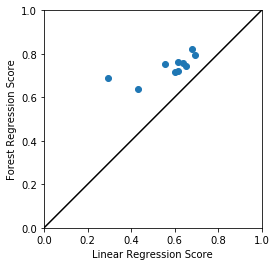

('budget', 0.3384031275640531)
('popularity', 0.10169516174209974)
('runtime', 0.018592491437324308)
('vote_count', 0.5179644896865266)
('vote_average', 0.011479111677455061)
('Action', 0.001265854609162398)
('Adventure', 0.00227871227020963)
('Fantasy', 0.0)
('Science Fiction', 0.0)
('Crime', 0.0026853600108842223)
('Drama', 0.0015522315688570767)
('Thriller', 0.0)
('Animation', 0.0005879798158977145)
('Family', 0.001062688910927346)
('Western', 0.0007522651804208923)
('Comedy', 0.0)
('Romance', 0.0)
('Horror', 0.0)
('Mystery', 0.0016805255261818151)
('War', 0.0)
('History', 0.0)
('Music', 0.0)
('Documentary', 0.0)
('TV Movie', 0.0)
('Foreign', 0.0)


In [14]:
# Determine the cross-validated correlation for linear and random forest models.
linear_regression_scores = cross_val_score(linear_regression, covariates, regression_outcome, cv=10, scoring=correlation)
forest_regression_scores = cross_val_score(forest_regression, covariates, regression_outcome, cv=10, scoring=correlation)

# Plot Results
plt.axes().set_aspect('equal', 'box')
plt.scatter(linear_regression_scores, forest_regression_scores)
plt.plot((0, 1), (0, 1), 'k-')

plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel("Linear Regression Score")
plt.ylabel("Forest Regression Score")

# Show the plot.
plt.show()

forest_regression.fit(positive_revenue_df[all_covariates], regression_outcome)
for row in zip(all_covariates, forest_regression.feature_importances_,):
    print(row)

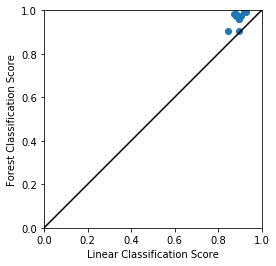

('budget', 0.08359719057310135)
('popularity', 0.4877045624202596)
('runtime', 0.03627645067457281)
('vote_count', 0.2108983363047868)
('vote_average', 0.0544354230045012)
('Action', 0.004901780068684141)
('Adventure', 0.01050519411619063)
('Fantasy', 0.014685679319053433)
('Science Fiction', 0.0034485713578329543)
('Crime', 0.003673793344462487)
('Drama', 0.02484362932062891)
('Thriller', 0.0018965793473123757)
('Animation', 0.0002657212639893513)
('Family', 0.008996712093599925)
('Western', 0.0009338293417977317)
('Comedy', 0.006298038524905772)
('Romance', 0.006568626316910688)
('Horror', 0.0)
('Mystery', 0.006101715382183856)
('War', 0.01002608405080379)
('History', 0.00850809449122243)
('Music', 0.0008386015199349613)
('Documentary', 0.008883658297862956)
('TV Movie', 0.0)
('Foreign', 0.005711728865401886)


In [15]:
# Determine the cross-validated accuracy for logistic and random forest models.
logistic_regression_scores = cross_val_score(logistic_regression, covariates, classification_outcome, cv=10, scoring=accuracy)
forest_classification_scores = cross_val_score(forest_classifier, covariates, classification_outcome, cv=10, scoring=accuracy)

# Plot Results
plt.axes().set_aspect('equal', 'box')
plt.scatter(logistic_regression_scores, forest_classification_scores)
plt.plot((0, 1), (0, 1), 'k-')

plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel("Linear Classification Score")
plt.ylabel("Forest Classification Score")

plt.show()

forest_classifier.fit(positive_revenue_df[all_covariates], classification_outcome)
for row in zip(all_covariates, forest_classifier.feature_importances_,):
    print(row)